In [11]:
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import talib

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm

import seaborn as sns; sns.set()

In [12]:
BTC = pd.read_csv('./data/BTC.csv', parse_dates=['Date'], index_col = 'Date')

# 캔들스틱 패턴 분류
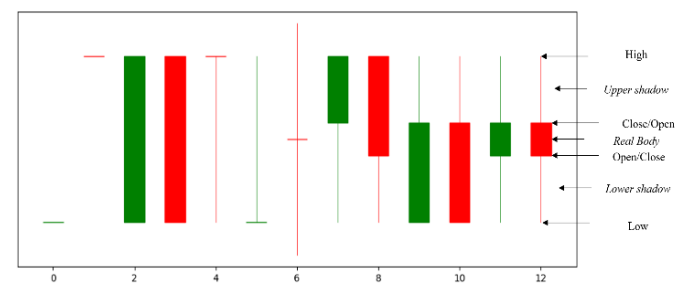

In [13]:
patterns = ['CDLCLOSINGMARUBOZU', 'CDLDOJI', 'CDLDRAGONFLYDOJI', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHIGHWAVE', 'CDLINVERTEDHAMMER', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLRICKSHAWMAN', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLTAKURI']
len(patterns)

16

In [14]:
def get_patterns(df):
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    # create columns for each pattern
    for candle in patterns:
        # below is same as;
        # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        df[candle] = getattr(talib, candle)(op, hi, lo, cl)
        
    return df

In [15]:
df = get_patterns(BTC)

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               3654 non-null   float64
 1   Open                3654 non-null   float64
 2   High                3654 non-null   float64
 3   Low                 3654 non-null   float64
 4   Volume              3654 non-null   float64
 5   Change              3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [17]:
df['CDLCLOSINGMARUBOZU'].unique()

array([   0, -100,  100])

# 기술적 모멘텀 지표

In [18]:
def get_indicators(df):
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    vo = df['Volume']
    
    df['ADX'] = talib.ADX(hi, lo, cl, timeperiod=14)
    df['APO'] = talib.APO(cl, fastperiod=12, slowperiod=26, matype=0)
    df['BOP'] = talib.BOP(op, hi, lo, cl)
    df['CCI'] = talib.CCI(hi, lo, cl, timeperiod=14)
    df['DX'] = talib.DX(hi, lo, cl, timeperiod=14)
    df['MACD'], df['MACDSIGNAL'], df['MACDHIST'] = talib.MACD(cl, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MFI'] = talib.MFI(hi, lo, cl, vo, timeperiod=14)
    df['MOM'] = talib.MOM(cl, timeperiod=14)
    df['RSI'] = talib.RSI(cl, timeperiod=14)
    df['WILLR'] = talib.WILLR(hi, lo, cl, timeperiod=14)
    df['BOLUP'], _, df['BOLLOW'] = talib.BBANDS(cl, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['EMA'] = talib.EMA(cl, timeperiod=50)
    
    return df

In [19]:
df = get_indicators(BTC)

In [20]:
plt.rcParams['figure.figsize'] = (20, 10)

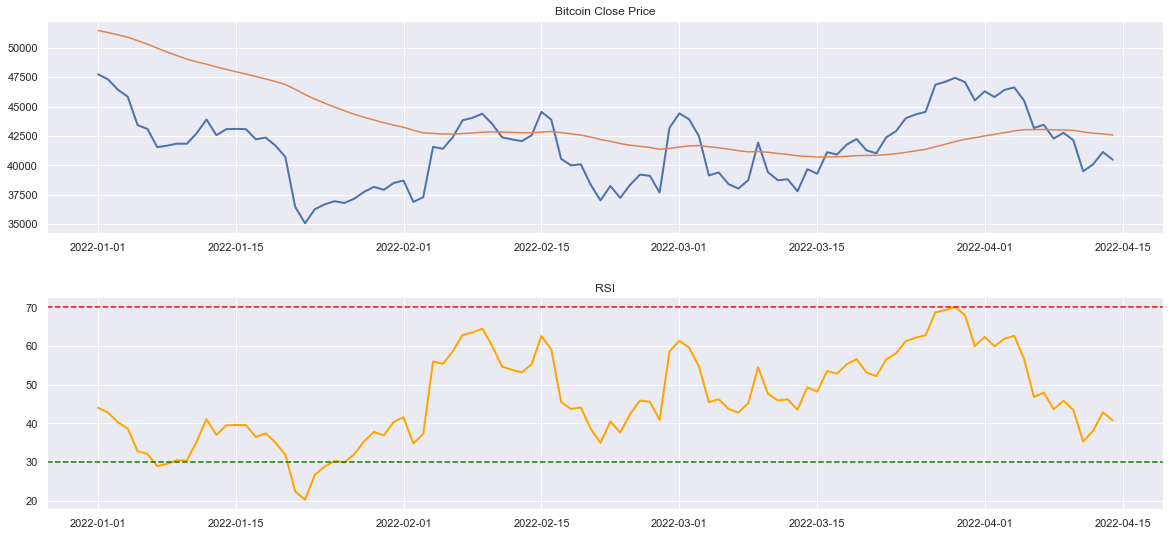

In [21]:
ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)

ax1.plot(df['2022']['Close'], linewidth=2)
ax1.plot(df['2022']['EMA'])
ax1.set_title('Bitcoin Close Price')

ax2.plot(df['2022']['RSI'], color='orange', linewidth=2)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'green')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'red')
ax2.set_title('RSI')
plt.show()

In [22]:
df.tail()

,Close,Open,High,Low,Volume,Change,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,MACD,MACDSIGNAL,MACDHIST,MFI,MOM,RSI,WILLR,BOLUP,BOLLOW,EMA
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-10,42138.0,42760.0,43421.0,41884.0,255830000.0,-0.0147,0,0,0,0,...,263.562739,882.393571,-618.830832,30.278836,-4721.0,43.496384,-95.977831,43766.607790,41753.792210,42977.155897
2022-04-11,39497.0,42144.0,42418.0,39202.0,608380000.0,-0.0627,0,0,0,0,...,-109.063993,684.102058,-793.166052,20.440014,-7608.0,35.305467,-96.694678,44714.467754,39335.532246,42840.679195
2022-04-12,40078.0,39507.0,40678.0,39265.0,468270000.0,0.0147,0,0,0,0,...,-353.417542,476.598138,-830.015680,12.498023,-7371.0,38.068484,-89.708647,43964.204317,38737.795683,42732.338834
2022-04-13,41133.0,40072.0,41515.0,39581.0,406700000.0,0.0263,0,0,0,0,...,-456.675535,289.943404,-746.618939,18.870910,-5942.0,42.842157,-77.071954,43567.015873,38678.184127,42669.619664
2022-04-14,40481.0,41133.0,41494.0,40340.0,341380000.0,-0.0159,0,0,0,0,...,-584.382789,115.078165,-699.460954,24.938967,-5044.0,40.751584,-84.464958,42483.399164,38847.400836,42583.791442


# 캔들스틱 8괘 분류
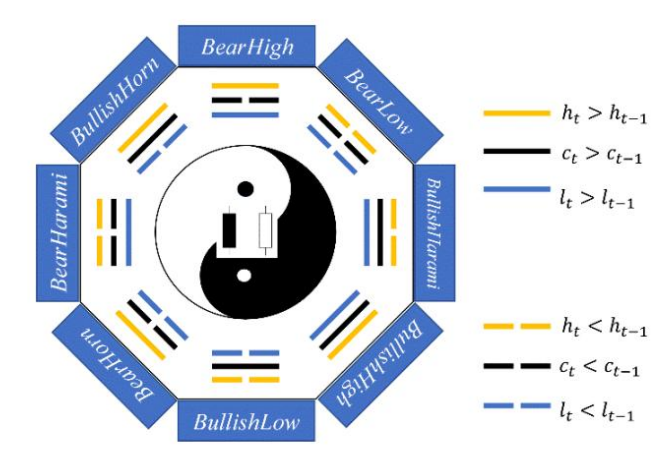

In [23]:
def eight_trigram(df):
    high_high = df['High'] >= df['High'].shift(1)
    high_low = df['High'] <= df['High'].shift(1)
    close_high = df['Close'] >= df['Close'].shift(1)
    close_low = df['Close'] <= df['Close'].shift(1)
    low_high = df['Low'] >= df['Low'].shift(1)
    low_low = df['Low'] <= df['Low'].shift(1)
    
    BearHorn = high_high & close_low & low_low
    BearHarami = high_low & close_low & low_high
    BearHigh = high_high & close_low & low_high
    BearLow = high_low & close_low & low_low
    BullishHorn = high_high & close_high & low_low
    BullishHarami = high_low & close_high & low_high
    BullishHigh = high_high & close_high & low_high
    BullishLow = high_low & close_high & low_low
    
    
    df['EightTri'] = 0
    df['EightTri'] = np.where(BearHorn, 1, df['EightTri'])
    df['EightTri'] = np.where(BearHarami, 2, df['EightTri'])
    df['EightTri'] = np.where(BearHigh, 3, df['EightTri'])
    df['EightTri'] = np.where(BearLow, 4, df['EightTri'])
    df['EightTri'] = np.where(BullishHorn, 5, df['EightTri'])
    df['EightTri'] = np.where(BullishHarami, 6, df['EightTri'])
    df['EightTri'] = np.where(BullishHigh, 7, df['EightTri'])
    df['EightTri'] = np.where(BullishLow, 8, df['EightTri'])
    

    df.loc[df.index[0], 'EightTri'] = random.randrange(1,8)
        
    return df

In [24]:
df = eight_trigram(BTC)

In [25]:
df['EightTri'].unique()

array([3, 7, 8, 4, 2, 6, 5, 1], dtype=int64)

In [26]:
df['Trend'] = 0
df['Trend'] = np.where(df['Close'] > df['EMA'], 1, 0)
df['Trend'].unique()

array([0, 1])

In [27]:
df.tail()

,Close,Open,High,Low,Volume,Change,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,MACDHIST,MFI,MOM,RSI,WILLR,BOLUP,BOLLOW,EMA,EightTri,Trend
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-10,42138.0,42760.0,43421.0,41884.0,255830000.0,-0.0147,0,0,0,0,...,-618.830832,30.278836,-4721.0,43.496384,-95.977831,43766.607790,41753.792210,42977.155897,1,0
2022-04-11,39497.0,42144.0,42418.0,39202.0,608380000.0,-0.0627,0,0,0,0,...,-793.166052,20.440014,-7608.0,35.305467,-96.694678,44714.467754,39335.532246,42840.679195,4,0
2022-04-12,40078.0,39507.0,40678.0,39265.0,468270000.0,0.0147,0,0,0,0,...,-830.015680,12.498023,-7371.0,38.068484,-89.708647,43964.204317,38737.795683,42732.338834,6,0
2022-04-13,41133.0,40072.0,41515.0,39581.0,406700000.0,0.0263,0,0,0,0,...,-746.618939,18.870910,-5942.0,42.842157,-77.071954,43567.015873,38678.184127,42669.619664,7,0
2022-04-14,40481.0,41133.0,41494.0,40340.0,341380000.0,-0.0159,0,0,0,0,...,-699.460954,24.938967,-5044.0,40.751584,-84.464958,42483.399164,38847.400836,42583.791442,2,0


# 시장데이터 병합

In [28]:
GOLD = pd.read_csv('./data/ZG.csv', parse_dates=['Date'], index_col = 'Date')
NDAQ = pd.read_csv('./data/IXIC.csv', parse_dates=['Date'], index_col = 'Date')
US10YT = pd.read_csv('./data/US10YT.csv', parse_dates=['Date'], index_col = 'Date')
VIX = pd.read_csv('./data/VIX.csv', parse_dates=['Date'], index_col = 'Date')

In [29]:
t1 = BTC.merge(GOLD, on='Date', how='left', suffixes=('_BTC', '_GLD'))
list_df = ['NDAQ', 'US10YT', 'VIX']
for x in list_df:
    t1 = t1.merge(globals()[x].add_suffix('_'+str(x)),
                 on='Date', how='left')
t1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3654 non-null   float64
 1   Open_BTC            3654 non-null   float64
 2   High_BTC            3654 non-null   float64
 3   Low_BTC             3654 non-null   float64
 4   Volume_BTC          3654 non-null   float64
 5   Change_BTC          3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [30]:
t1.Volume_GLD.fillna(0, inplace=True)
t1.Change_GLD.fillna(0, inplace=True)
t1.Volume_NDAQ.fillna(0, inplace=True)
t1.Change_NDAQ.fillna(0, inplace=True)
t1.Change_US10YT.fillna(0, inplace=True)
t1.Volume_VIX.fillna(0, inplace=True)
t1.Change_VIX.fillna(0, inplace=True)

In [31]:
df = t1.fillna(0)
df.dropna(inplace=True)
df.isna().sum()

Close_BTC     0
Open_BTC      0
High_BTC      0
Low_BTC       0
Volume_BTC    0
             ..
Open_VIX      0
High_VIX      0
Low_VIX       0
Volume_VIX    0
Change_VIX    0
Length: 62, dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2012-04-13 to 2022-04-14
Data columns (total 62 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3654 non-null   float64
 1   Open_BTC            3654 non-null   float64
 2   High_BTC            3654 non-null   float64
 3   Low_BTC             3654 non-null   float64
 4   Volume_BTC          3654 non-null   float64
 5   Change_BTC          3654 non-null   float64
 6   CDLCLOSINGMARUBOZU  3654 non-null   int32  
 7   CDLDOJI             3654 non-null   int32  
 8   CDLDRAGONFLYDOJI    3654 non-null   int32  
 9   CDLGRAVESTONEDOJI   3654 non-null   int32  
 10  CDLHAMMER           3654 non-null   int32  
 11  CDLHANGINGMAN       3654 non-null   int32  
 12  CDLHIGHWAVE         3654 non-null   int32  
 13  CDLINVERTEDHAMMER   3654 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3654 non-null   int32  
 15  CDLLONGLINE         3654 non-null   i

In [33]:
df['target'] = df['Close_BTC'].pct_change()
df['target'] = np.where(df['target'] > 0 , 1, -1)
df['target'] = df['target'].shift(-1)
df = df.dropna()

In [34]:
df['target'].tail()

Date
2022-04-09   -1.0
2022-04-10   -1.0
2022-04-11    1.0
2022-04-12    1.0
2022-04-13   -1.0
Name: target, dtype: float64

In [35]:
y_var = df['target']
x_var = df.drop(['target', 'Volume_VIX'], axis=1) 
x_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2012-04-13 to 2022-04-13
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_BTC           3653 non-null   float64
 1   Open_BTC            3653 non-null   float64
 2   High_BTC            3653 non-null   float64
 3   Low_BTC             3653 non-null   float64
 4   Volume_BTC          3653 non-null   float64
 5   Change_BTC          3653 non-null   float64
 6   CDLCLOSINGMARUBOZU  3653 non-null   int32  
 7   CDLDOJI             3653 non-null   int32  
 8   CDLDRAGONFLYDOJI    3653 non-null   int32  
 9   CDLGRAVESTONEDOJI   3653 non-null   int32  
 10  CDLHAMMER           3653 non-null   int32  
 11  CDLHANGINGMAN       3653 non-null   int32  
 12  CDLHIGHWAVE         3653 non-null   int32  
 13  CDLINVERTEDHAMMER   3653 non-null   int32  
 14  CDLLONGLEGGEDDOJI   3653 non-null   int32  
 15  CDLLONGLINE         3653 non-null   i

In [36]:
up=df[df['target']==1].target.count()
total=df.target.count()
print('up/down ratio: {0:.2f}'.format((up/total)))

up/down ratio: 0.53


In [37]:
X_train, X_test, y_train, y_test = train_test_split(x_var, 
                                                    y_var, 
                                                    test_size=0.2, 
                                                    shuffle=False, 
                                                    random_state=3)

train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
 1.0    0.523614
-1.0    0.476386
Name: target, dtype: float64
test set label ratio
 1.0    0.53762
-1.0    0.46238
Name: target, dtype: float64


In [38]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

In [30]:
n_estimators = range(10,400,10)

xg_parameters ={'max_depth' : [3,4,5,6],
                'objective':['binary:logistic'],
                'n_estimators': n_estimators, 
                'learning_rate':[0.01, 0.1], 
                'gamma': [0.5, 1, 2], 
                'random_state':[3],
               'early_stopping_rounds':[30],
               'eval_metric' : ['logloss'], 
                'eval_set' : [[X_test, y_test]],
               'scoring':['f1']}

# xgb_cv = TimeSeriesSplit(n_splits=5).split(X_train)
xgb_cv=KFold(n_splits=5)

In [31]:
# xgb_dis = XGBClassifier(eval_metric='error', n_estimators=400, learning_rate=0.1, max_depth=3, random_state=3, early_stopping_rounds=30)
xgb_model = XGBClassifier()

xgb_clf = GridSearchCV(xgb_model, xg_parameters, n_jobs=-1, 
                       cv=xgb_cv,
                       verbose=1
#                        , n_folds=5, shuffle=True, 
#                    scoring='roc_auc',
                      )

# xgb_dis.fit(X_train, y_train)
# xgb_pred = xgb_dis.predict(X_test)

xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)

Fitting 5 folds for each of 936 candidates, totalling 4680 fits
[22:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "eval_set", "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [32]:
xgb_clf.score(X_train, y_train)

0.5927446954140999

In [33]:
print("xgb best params : ", xgb_clf.best_params_)
print(get_confusion_matrix(y_test, xgb_pred))

xgb best params :  {'early_stopping_rounds': 30, 'eval_metric': 'logloss', 'eval_set': [            Close_BTC  Open_BTC  High_BTC  Low_BTC   Volume_BTC  Change_BTC  \
Date                                                                          
2020-04-13     6841.3    6918.1    6920.3   6618.5    1250000.0     -0.0110   
2020-04-14     6850.9    6841.8    6970.8   6768.6     999530.0      0.0014   
2020-04-15     6629.1    6851.3    6929.5   6615.9    1000000.0     -0.0324   
2020-04-16     7085.6    6629.1    7159.7   6520.5    1540000.0      0.0689   
2020-04-17     7035.8    7085.5    7142.8   7005.8     810100.0     -0.0070   
...               ...       ...       ...      ...          ...         ...   
2022-04-09    42767.0   42275.0   42809.0  42129.0  165160000.0      0.0116   
2022-04-10    42138.0   42760.0   43421.0  41884.0  255830000.0     -0.0147   
2022-04-11    39497.0   42144.0   42418.0  39202.0  608380000.0     -0.0627   
2022-04-12    40078.0   39507.0   40678.0  

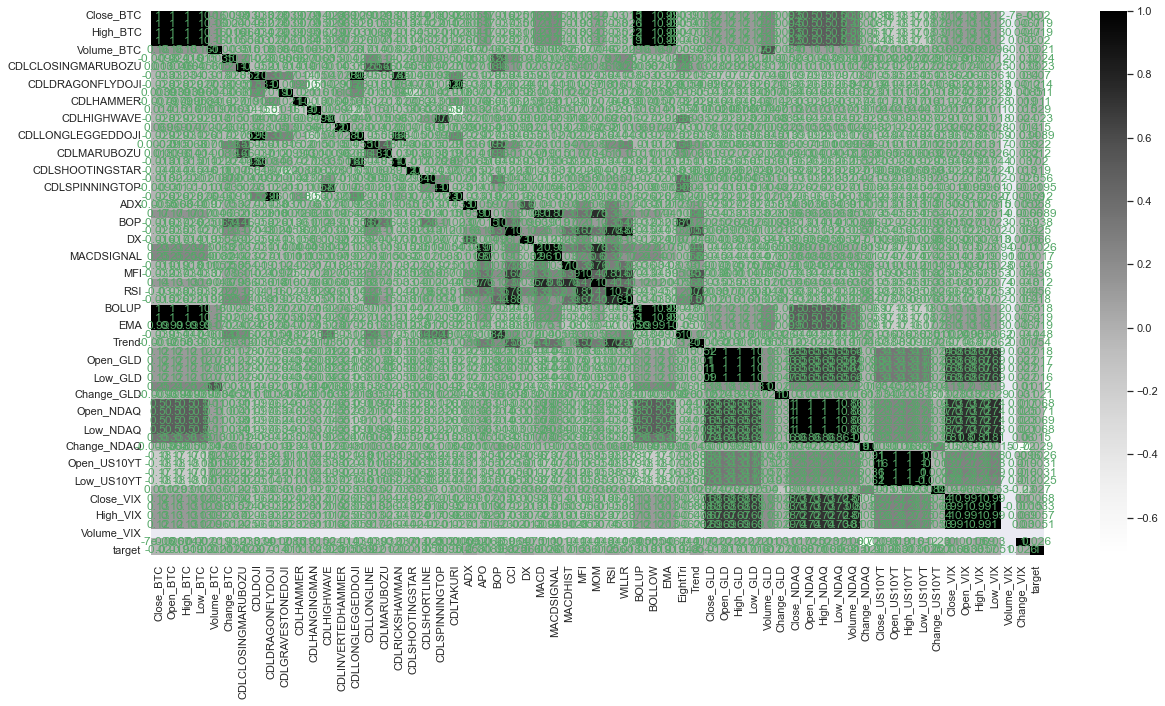

In [39]:
ax = sns.heatmap(df.corr(), annot=True, annot_kws=dict(color='g'), cmap='Greys')
plt.show()

# 모델 저장 및 테스트

In [40]:
import joblib

In [41]:
# joblib.dump(xgb_clf, './trader1.pkl') 모델 저장

In [42]:
trader1 = joblib.load('./trader1.pkl')

In [43]:
trader1.score(X_test, y_test)

0.5471956224350205

In [44]:
#이더리움 테스트

cols = {'close':'Close', 'open':'Open', 'high':'High', 'low':'Low', 'volume':'Volume'}
ETH = pd.read_csv('./data/ETHUSDT1d.csv', parse_dates=['time'], index_col = 'time')
ETH = ETH.rename_axis('Date')
ETH = ETH.iloc[:, 1:6]
ETH = ETH[['close', 'open', 'high', 'low', 'volume']]
ETH.rename(columns=cols, inplace=True)
ETH['Change'] = (ETH['Close'] - ETH['Close'].shift(1)) / ETH['Close'].shift(1) * 100

In [45]:
ETH = get_patterns(ETH)
ETH = eight_trigram(ETH)
ETH = get_indicators(ETH)
ETH['Trend'] = 0
ETH['Trend'] = np.where(ETH['Close'] > ETH['EMA'], 1, 0)


In [46]:
ETH = ETH.merge(GOLD, on='Date', how='left', suffixes=('_ETH', '_GLD'))
list_df = ['NDAQ', 'US10YT', 'VIX']
for x in list_df:
    ETH = ETH.merge(globals()[x].add_suffix('_'+str(x)),
                 on='Date',
                 how='left')

In [47]:
ETH.Volume_GLD.fillna(0, inplace=True)
ETH.Change_GLD.fillna(0, inplace=True)
ETH.Volume_NDAQ.fillna(0, inplace=True)
ETH.Change_NDAQ.fillna(0, inplace=True)
ETH.Change_US10YT.fillna(0, inplace=True)
ETH.Volume_VIX.fillna(0, inplace=True)
ETH.Change_VIX.fillna(0, inplace=True)

In [48]:
ETH = ETH.fillna(0)
ETH.dropna(inplace=True)

In [49]:
ETH['target'] = ETH['Close_ETH'].pct_change()
ETH['target'] = np.where(ETH['target'] > 0 , 1, -1)
ETH['target'] = ETH['target'].shift(-1)
ETH['target'].fillna(0, inplace=True)

ETH['target'].tail()

y_var = ETH['target']
x_var = ETH.drop(['target', 'Volume_VIX'], axis=1) 
x_var.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2020-12-01 to 2022-04-14
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close_ETH           500 non-null    float64
 1   Open_ETH            500 non-null    float64
 2   High_ETH            500 non-null    float64
 3   Low_ETH             500 non-null    float64
 4   Volume_ETH          500 non-null    float64
 5   Change_ETH          500 non-null    float64
 6   CDLCLOSINGMARUBOZU  500 non-null    int32  
 7   CDLDOJI             500 non-null    int32  
 8   CDLDRAGONFLYDOJI    500 non-null    int32  
 9   CDLGRAVESTONEDOJI   500 non-null    int32  
 10  CDLHAMMER           500 non-null    int32  
 11  CDLHANGINGMAN       500 non-null    int32  
 12  CDLHIGHWAVE         500 non-null    int32  
 13  CDLINVERTEDHAMMER   500 non-null    int32  
 14  CDLLONGLEGGEDDOJI   500 non-null    int32  
 15  CDLLONGLINE         500 non-null    in

In [50]:
pred_eth = trader1.predict(x_var)

In [51]:
pred_eth[-1]

1.0

In [52]:
trader1.score(x_var, y_var)

0.542

In [53]:
x_var.tail(1)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,Volume_ETH,Change_ETH,CDLCLOSINGMARUBOZU,CDLDOJI,CDLDRAGONFLYDOJI,CDLGRAVESTONEDOJI,...,Close_US10YT,Open_US10YT,High_US10YT,Low_US10YT,Change_US10YT,Close_VIX,Open_VIX,High_VIX,Low_VIX,Change_VIX
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-14,3115.27,3116.53,3148.0,3108.05,166710.875,-0.037864,0,100,0,100,...,2.709,2.699,2.717,2.656,0.0024,21.75,21.82,21.87,21.44,-0.0032


In [94]:
# 모든 코인 테스트
cols = {'close':'Close', 'open':'Open', 'high':'High', 'low':'Low', 'volume':'Volume'}
scores = {"coin": [],
          "score": [],
          "today": []};
path = "./Data/"

file_list = os.listdir(path)
file_list_csv = [file for file in file_list if file.endswith("USDT1d.csv")]

In [95]:
print(len(file_list_csv))
print(file_list_csv[0])

141
1000SHIBUSDT1d.csv


In [96]:
import re

In [100]:
p = re.compile('.+(?=USDT)')

In [98]:
p = re.compile('.+(USDT)')

In [101]:
coin = p.search(file_list_csv[32]).group()
print(coin)

BTS


In [102]:
i = 0
for symbol in file_list_csv:
#     if i == len(file_list_csv):   # 일봉데이터 n일 이상일 경우만 순위 포함
#         break
    coin = p.search(file_list_csv[i]).group()
    
    df = pd.read_csv(path+symbol, parse_dates=['time'], index_col = 'time')
#     if len(df) < 300:   # 일봉데이터 n일 이상일 경우만 순위 포함
#         i += 1
#         pass
    df = df.rename_axis('Date')
    df = df.iloc[:, 1:6]
    df = df[['close', 'open', 'high', 'low', 'volume']]
    df.rename(columns=cols, inplace=True)
    df['Change'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1) * 100
    df = get_patterns(df)
    df = eight_trigram(df)
    df = get_indicators(df)
    df['Trend'] = 0
    df['Trend'] = np.where(df['Close'] > df['EMA'], 1, 0)

  
    df = df.merge(GOLD, on='Date', how='left', suffixes=('_'+coin, '_GLD'))
    list_df = ['NDAQ', 'US10YT', 'VIX']
    for x in list_df:
        df = df.merge(globals()[x].add_suffix('_'+str(x)),
                     on='Date',
                     how='left')

    df.Volume_GLD.fillna(0, inplace=True)
    df.Change_GLD.fillna(0, inplace=True)
    df.Volume_NDAQ.fillna(0, inplace=True)
    df.Change_NDAQ.fillna(0, inplace=True)
    df.Change_US10YT.fillna(0, inplace=True)
    df.Volume_VIX.fillna(0, inplace=True)
    df.Change_VIX.fillna(0, inplace=True)

    df = df.fillna(0)
    df.dropna(inplace=True)

    df['target'] = df['Close_'+coin].pct_change()
    df['target'] = np.where(df['target'] > 0 , 1, -1)
    df['target'] = df['target'].shift(-1)
    df['target'].fillna(0, inplace=True)


    y_var = df['target']
    x_var = df.drop(['target', 'Volume_VIX'], axis=1) 
    
    
    pred = trader1.predict(x_var)
    
    scores["coin"].append(file_list_csv[i])
    scores["score"].append(trader1.score(x_var, y_var))
    scores["today"].append(pred[-1])
                
    i += 1

In [103]:
df_rank = pd.DataFrame(scores)
df_rank['today'] = np.where(df_rank['today'] == 1, 'long', 'short')
df_rank

,coin,score,today
0,1000SHIBUSDT1d.csv,0.488235,long
1,1INCHUSDT1d.csv,0.500000,long
2,AAVEUSDT1d.csv,0.521008,long
3,ADAUSDT1d.csv,0.508000,short
4,AKROUSDT1d.csv,0.504000,long
...,...,...,...
108,YFIUSDT1d.csv,0.508000,long
109,ZECUSDT1d.csv,0.500000,long
110,ZENUSDT1d.csv,0.498876,long
111,ZILUSDT1d.csv,0.524457,long


In [104]:
df_rank.sort_values('score', ascending=False)

,coin,score,today
61,KSMUSDT1d.csv,0.625000,long
9,ANTUSDT1d.csv,0.605263,long
45,FILUSDT1d.csv,0.576000,long
99,TRBUSDT1d.csv,0.554000,long
76,ONEUSDT1d.csv,0.552000,long
...,...,...,...
64,LRCUSDT1d.csv,0.451613,long
12,ATAUSDT1d.csv,0.448276,long
63,LITUSDT1d.csv,0.444976,long
102,WAVESUSDT1d.csv,0.441176,long


In [77]:
df_rank.describe()

,score
count,252.000000
mean,0.509920
std,0.031545
min,0.285714
25%,0.496302
50%,0.514000
75%,0.526000
max,0.625000


# 백테스팅

In [64]:
import quantstats as qs

In [65]:
rank = df_rank.sort_values('score', ascending=False)
rank = list(rank['coin'])
print("len : ", len(rank))
print("Top 5 : ", rank[:5])
print("Low 5 : ", rank[136:])

len :  141
Top 5 :  ['FLOWUSDT1d.csv', 'ANCUSDT1d.csv', 'DEFIUSDT1d.csv', 'ONTUSDT1d.csv', 'KAVAUSDT1d.csv']
Low 5 :  ['APEUSDT1d.csv', 'GALAUSDT1d.csv', 'RAYUSDT1d.csv', 'WOOUSDT1d.csv', 'BNXUSDT1d.csv']


In [66]:
fee = 0.04 / 100 # Binance taker 수수료 0.04%
Balance = 10000 # 시작금액 10000

def backtest(coin):
    df = pd.read_csv(path+coin, parse_dates=['time'], index_col = 'time')
    df = df.rename_axis('Date')
    df = df.iloc[:, 1:6]
    df = df[['close', 'open', 'high', 'low', 'volume']]
    df.rename(columns=cols, inplace=True)
    df['Change'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)
    df = get_patterns(df)
    df = eight_trigram(df)
    df = get_indicators(df)
    df['Trend'] = 0
    df['Trend'] = np.where(df['Close'] > df['EMA'], 1, 0)

  
    df = df.merge(GOLD, on='Date', how='left', suffixes=('_'+coin, '_GLD'))
    list_df = ['NDAQ', 'US10YT', 'VIX']
    for x in list_df:
        df = df.merge(globals()[x].add_suffix('_'+str(x)),
                     on='Date',
                     how='left')

    df.Volume_GLD.fillna(0, inplace=True)
    df.Change_GLD.fillna(0, inplace=True)
    df.Volume_NDAQ.fillna(0, inplace=True)
    df.Change_NDAQ.fillna(0, inplace=True)
    df.Change_US10YT.fillna(0, inplace=True)
    df.Volume_VIX.fillna(0, inplace=True)
    df.Change_VIX.fillna(0, inplace=True)

    df = df.fillna(0)
    df.dropna(inplace=True)

    df['target'] = df['Close_'+coin].pct_change()
    df['target'] = np.where(df['target'] > 0 , 1, -1)
    df['target'] = df['target'].shift(-1)
    df['target'].fillna(0, inplace=True)


    y_var = df['target']
    x_var = df.drop(['target', 'Volume_VIX'], axis=1) 
    
    
    pred = trader1.predict(x_var)
#     pred = np.where(pred>0, -1, 1)
    df['pred'] = pred
    df['Balance'] = Balance
    
    for i in range(len(df)-1):
        bid = (df.iloc[i]['Balance'] - (df.iloc[i]['Balance'] * fee))
        ret = (df.iloc[i]['Change_'+coin] * df.iloc[i]['Balance'])
        long = df.iloc[i]['Change_'+coin] > 0
        short = df.iloc[i]['Change_'+coin] < 0
        
        if long and pred[i] > 0: # long True
            # (수수료를 뺀 잔고) +  (수익실현 금액)
            df['Balance'].iloc[i+1] = bid + ret
        elif long and pred[i] < 0: # long False
            df['Balance'].iloc[i+1] = bid - ret
        elif short and pred[i] < 0: # short True
            df['Balance'].iloc[i+1] = bid + (abs(df.iloc[i]['Change_'+coin]) * df.iloc[i]['Balance'])
        elif short and pred[i] > 0: # short False
            df['Balance'].iloc[i+1] = bid - (abs(df.iloc[i]['Change_'+coin]) * df.iloc[i]['Balance'])
    
    
    return df[['Close_'+coin, 'Change_'+coin, 'pred', 'Balance']]

In [105]:
result = backtest('KSMUSDT1d.csv')

In [106]:
result.describe()

,Close_KSMUSDT1d.csv,Change_KSMUSDT1d.csv,pred,Balance
count,500.000000,500.000000,500.000000,500.000000
mean,264.130772,0.005077,0.936000,35557.920129
std,126.051624,0.075757,0.352353,21796.089873
min,44.953000,-0.430929,-1.000000,8594.239495
25%,164.715000,-0.039725,1.000000,18688.074897
50%,272.656000,0.003224,1.000000,29756.831255
75%,366.410000,0.041309,1.000000,44796.664773
max,597.890000,0.342822,1.000000,109006.935791


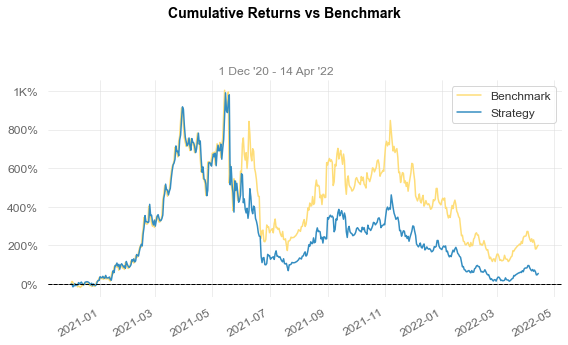

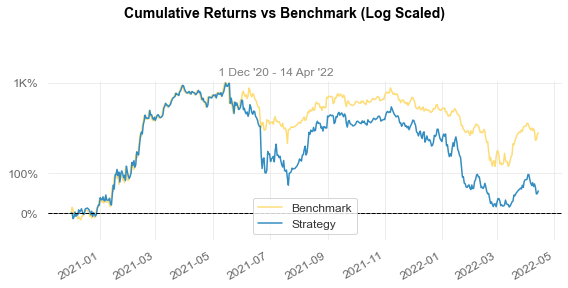

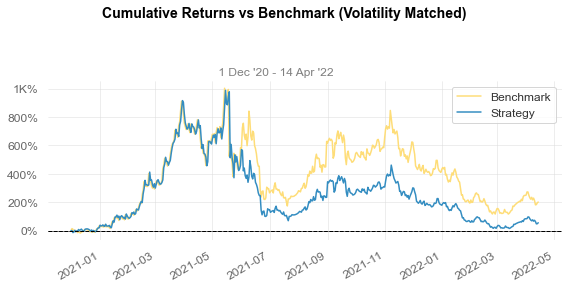

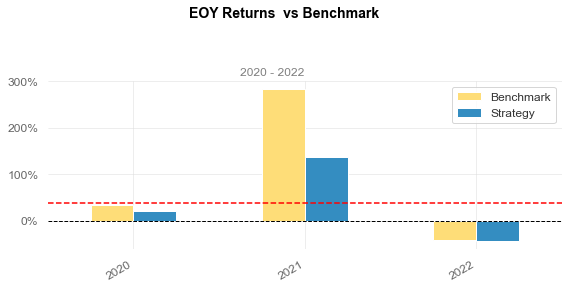

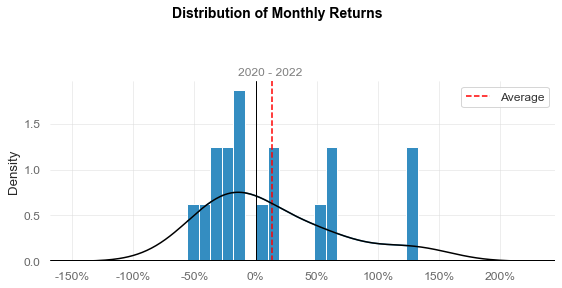

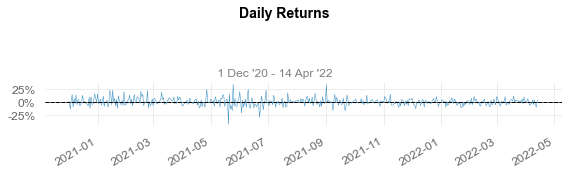

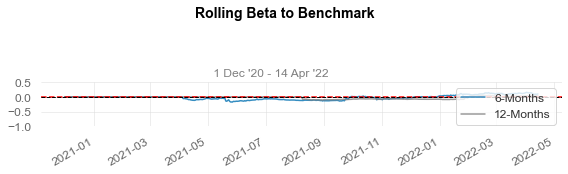

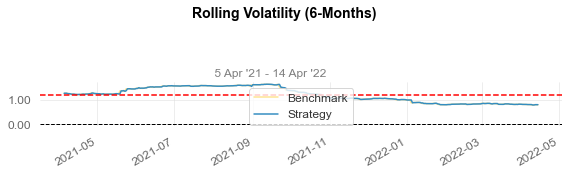

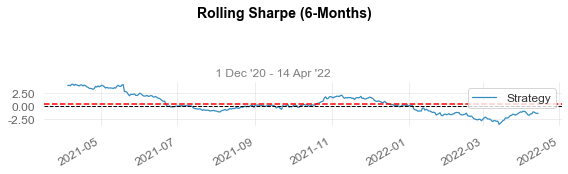

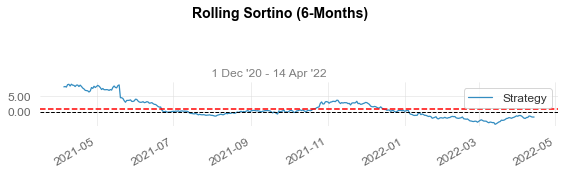

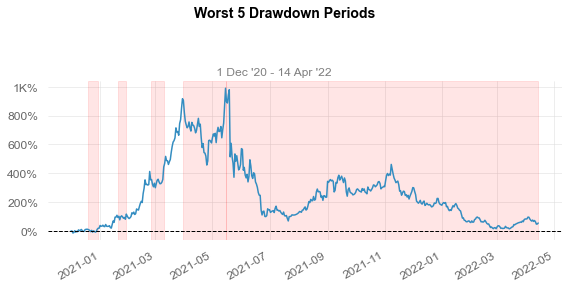

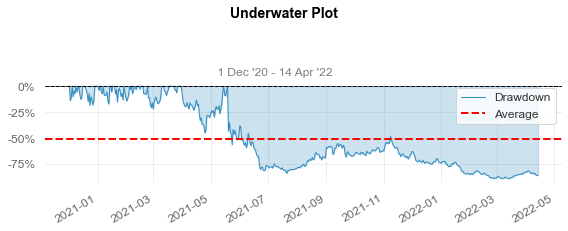

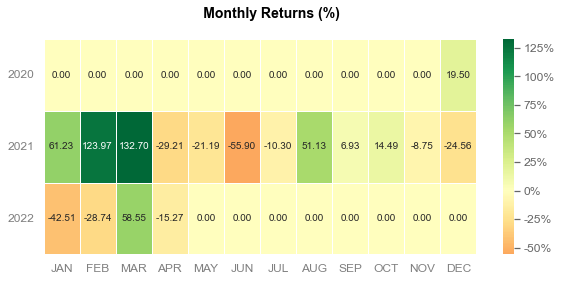

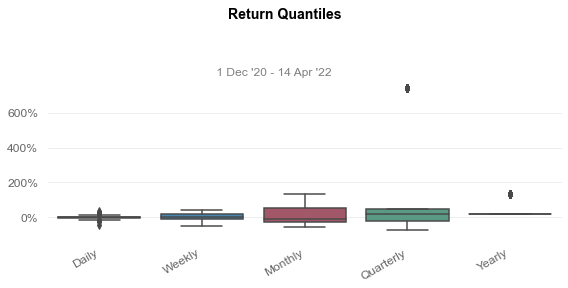

In [107]:
# qs.reports.plots(result['Balance'], result['Change_'+rank[129]], mode='full') #1번째 순위 코인의 투자전략 적용 vs 기존 코인의 가격흐름
qs.reports.plots(result['Balance'], result['Close_KSMUSDT1d.csv'], mode='full')

In [349]:
backtests = {"coin": [],
          "balance": []};
for i in rank:
    vals = backtest(i)
    backtests['coin'].append(i)
    backtests['balance'].append(vals.iloc[-1]['Balance'])

In [351]:
backtests = pd.DataFrame(backtests)

,coin,balance
0,FLOWUSDT1d.csv,14999.429168
1,ANCUSDT1d.csv,11911.025484
2,DEFIUSDT1d.csv,20881.415162
3,ONTUSDT1d.csv,8934.189560
4,KAVAUSDT1d.csv,26600.529262
...,...,...
136,APEUSDT1d.csv,3571.824871
137,GALAUSDT1d.csv,20127.291102
138,RAYUSDT1d.csv,890.904021
139,WOOUSDT1d.csv,10588.948108


In [352]:
backtests.sort_values('balance', ascending=False)

,coin,balance
8,SOLUSDT1d.csv,705745.103818
26,FTMUSDT1d.csv,593623.141246
63,MATICUSDT1d.csv,479684.338943
97,DOGEUSDT1d.csv,340323.157912
102,AXSUSDT1d.csv,258557.326884
...,...,...
87,ONEUSDT1d.csv,1193.742600
81,DGBUSDT1d.csv,1145.393093
111,OGNUSDT1d.csv,892.309245
138,RAYUSDT1d.csv,890.904021
